In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src") if "../src" not in sys.path else None 

from CANN_burak import CANN_burak

In [3]:
model = CANN_burak()

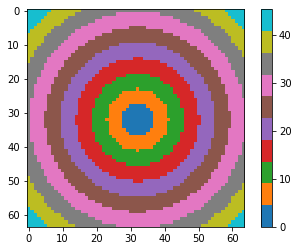

In [4]:
# plot norm of neural sheet coordinates
plt.imshow(np.linalg.norm(model.sheet, axis = -1), cmap = "tab10") # completely uninformative cmap
plt.colorbar()

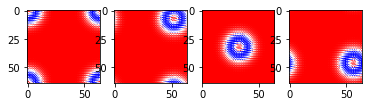

In [5]:
w = model.init_periodic_recurrent_weights(model.sheet)

show_cells = [0, 500, 2080,  3000]
fig, axs = plt.subplots(1, len(show_cells))

for i, cell in enumerate(show_cells):
    axs[i].imshow(w[cell].reshape((model.nl, model.nl)), cmap = "bwr")
plt.show()

In [6]:
y = model.init_shifts()

In [7]:
# print some units for sanity
for i in range(4):
    for j in range(4):
        print(y[i,j], end = "")
    print('\n')

[1. 0.][0. 1.][1. 0.][0. 1.]

[-1. -0.][-0. -1.][-1. -0.][-0. -1.]

[1. 0.][0. 1.][1. 0.][0. 1.]

[-1. -0.][-0. -1.][-1. -0.][-0. -1.]



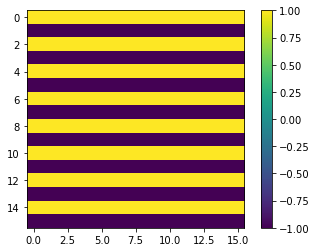

In [8]:
# plot sum of shifts along last axis (should be +1 or -1)
plt.imshow(np.sum(y[:16,:16],axis=-1))
plt.colorbar();

In [9]:
init_state = np.random.uniform(0, 1, (64, 64))
h = np.ravel(init_state)

v = np.array([0,1])*0
model = CANN_burak(Ng=4096,l=0)# "if l, alpha =0, the network develops a static triangular grid" 

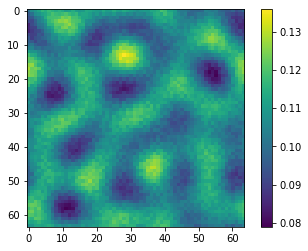

In [10]:
for i in range(100):
    h = model.forward(h, v)
plt.imshow(h.reshape((64, 64)))
plt.colorbar()